# Moment curvature

Introduction to `sympy`, `numpy` and `scipy` to write semi-analytical models for the reinforced cross-sectional combinations.

This notebook starts with the basic expressions for bending.

## Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()

In [2]:
from scipy.optimize import newton, brentq, root
###

Introduce the cross sectional curvature $\kappa$ which is equal to
\begin{align}
\kappa = \frac{\partial \varepsilon_{xx}}{\partial z}
\end{align}

In [3]:
kappa = sp.Symbol('kappa', real=True, nonpositive=True)

In [4]:
eps_top = sp.symbols(
    'varepsilon_top', real=True, nonpositive=True )
eps_bot = sp.symbols(
    'varepsilon_bot', real=True, nonnegative=True )
b, h, z = sp.symbols('b, h, z', nonnegative = True )

**Parameters of the constitutive law**

In [5]:
E_ct, E_cc, eps_cr, eps_tu, mu = sp.symbols(
    r'E_ct, E_cc, varepsilon_cr, varepsilon_tu, mu', 
    real=True, nonnegative=True
)

In [6]:
eps_cy, eps_cu = sp.symbols(
    r'varepsilon_cy, varepsilon_cu', real=True, nonpositive=True
)

**Linear profile** of strain over the height

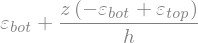

In [7]:
eps_z = eps_bot + z * (eps_top - eps_bot) / h
eps_z

## Concrete constitutive law

In [8]:
eps = sp.Symbol('varepsilon', real=True )

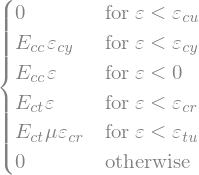

In [9]:
sig_c_eps = sp.Piecewise(
    (0, eps < eps_cu),
    (E_cc * eps_cy, eps < eps_cy),
    (E_cc * eps, eps < 0), 
    (E_ct * eps, eps < eps_cr),
    (mu * E_ct * eps_cr, eps < eps_tu),
    (0, eps >= eps_tu)
)
sig_c_eps

**Define the material data:**

In [10]:
# model_data = {
#     b : 50,
#     h : 100,
#     E_ct : 24000, E_cc : 25000, 
#     eps_cr : 0.001, 
#     eps_yield:-0.003, 
#     eps_c_fail:-0.01, 
#     sigma_pc:10,
#     eps_fail : 0.003
# }

geo_data = {
    b : 100, # not given in paper
    h : 100, # not given in paper
}
# data from paper, to rreproduce fig.7
concrete_data = {
    E_ct : 24000, 
    E_cc : 24000, 
    eps_cr : 125e-6, 
    eps_cy:-26/24000, # = -26/E_cc  where f'c = 26 mpa
    eps_cu:-0.0035, #
    mu:0.33, # 0.33*24000*125e-6, # = 0.33*E_ct*eps_cr
    eps_tu : 0.02,
}

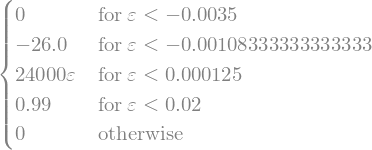

In [11]:
sig_c_eps.subs(concrete_data)

In [12]:
get_sig_c_eps = sp.lambdify(eps, sig_c_eps.subs(concrete_data), 'numpy' )

**Plot the material behavior**

In [13]:
eps_min, eps_max = -0.005, 0.022
fig, ax1 = plt.subplots(1,1, figsize=(12,3.5)) 
eps_data = np.linspace(eps_min, eps_max, 1000)
ax1.plot(eps_data, get_sig_c_eps(eps_data),color='black')
ax1.fill_between(eps_data, get_sig_c_eps(eps_data),color='black', alpha=0.1)
ax1.set_xlabel(r'$\varepsilon\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\sigma\;\;\mathrm{[MPa]}$'); 
ax1.set_title('concrete behhavior');

**Reinforcement behavior**

In [14]:
eps_sy, E_s = sp.symbols('varepsilon_sy, E_s')

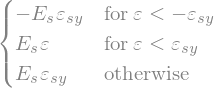

In [15]:
sig_s = sp.Piecewise(
    (-E_s * eps_sy, eps < -eps_sy),
    (E_s * eps, eps < eps_sy), 
    (E_s * eps_sy, eps >= eps_sy)
)
sig_s

In [16]:
reinforcement_data = {
    E_s : 210000,
    eps_sy : 0.002
}

In [17]:
sig_s.subs(reinforcement_data)

In [18]:
get_sig_s_eps = sp.lambdify(eps, sig_s.subs(reinforcement_data), 'numpy' )

In [19]:
eps_min, eps_max = -0.005, 0.005
fig, ax1 = plt.subplots(1,1, figsize=(12,3.5)) 
eps_data = np.linspace(eps_min, eps_max, 1000)
ax1.plot(eps_data, get_sig_s_eps(eps_data),color='black')
ax1.fill_between(eps_data, get_sig_s_eps(eps_data),color='black', alpha=0.1)
ax1.set_xlabel(r'$\varepsilon\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\sigma\;\;\mathrm{[MPa]}$'); 
ax1.set_title('concrete behhavior');

**Stress over the cross section**

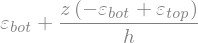

In [20]:
eps_z

In [21]:
sig_c_z = sig_c_eps.subs(eps, eps_z)
sig_c_z

Express $\varepsilon_\mathrm{top}$ as a function of $\kappa$ and $\varepsilon_\mathrm{bot}$

In [22]:
curvature_definition = kappa + eps_z.diff(z)

In [23]:
subs_eps = {
    eps_top : sp.solve(curvature_definition, eps_top)[0]
}
subs_eps

In [24]:
get_eps_z = sp.lambdify(
    (kappa, eps_bot, z), eps_z.subs(subs_eps), 'numpy'
)

Use the substitution in expression of stresses over the height

In [25]:
sig_c_z_lin = sig_c_z.subs(subs_eps)
sig_c_z_lin

# Reinforcement bar
Define a position of a bar $z_i$ with associated area $A_i$ and E-Modulus $E_j$.

**Reinforcement behavior**

In [26]:
eps_sy, E_s = sp.symbols('varepsilon_sy, E_s')

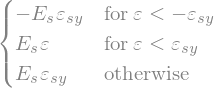

In [27]:
sig_s_eps = sp.Piecewise(
    (-E_s * eps_sy, eps < -eps_sy),
    (E_s * eps, eps < eps_sy), 
    (E_s * eps_sy, eps >= eps_sy)
)
sig_s_eps

In [28]:
reinforcement_data = {
    E_s : 210000,
    eps_sy : 0.002
}

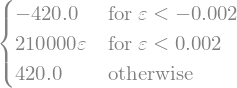

In [29]:
sig_s_eps.subs(reinforcement_data)

In [30]:
get_sig_s_eps = sp.lambdify(eps, sig_s_eps.subs(reinforcement_data), 'numpy' )

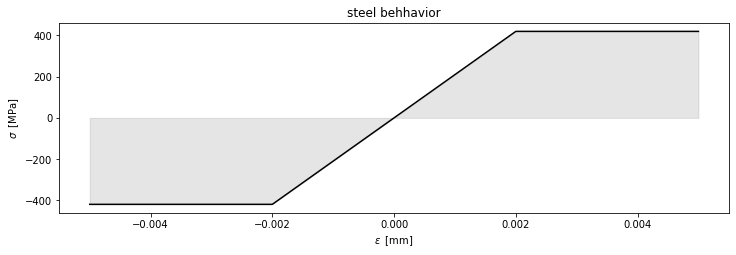

In [31]:
eps_min, eps_max = -0.005, 0.005
fig, ax1 = plt.subplots(1,1, figsize=(12,3.5)) 
eps_data = np.linspace(eps_min, eps_max, 1000)
ax1.plot(eps_data, get_sig_s_eps(eps_data),color='black')
ax1.fill_between(eps_data, get_sig_s_eps(eps_data),color='black', alpha=0.1)
ax1.set_xlabel(r'$\varepsilon\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\sigma\;\;\mathrm{[MPa]}$'); 
ax1.set_title('steel behhavior');

In [32]:
# from paper rho_g=0.005 therefore
rho_g = 0.015
A_s = float((b * h * rho_g).subs(geo_data))
z_j = np.array([10], dtype=np.float_)
A_j = np.array([A_s], dtype=np.float_) 
# because in this case rho_g = 0.5/(100*1)
A_j

array([150.])

# Model data

In [33]:
sig_c_z_lin.subs(concrete_data)

In [34]:
get_sig_c_z = sp.lambdify(
    (kappa, eps_bot, z), sig_c_z_lin.subs(concrete_data), 'numpy'
)

# Stress resultants

Discretization of the cross section supplying the array of vertical coordinates $z$. Index $m$ denotes as a material points.

In [35]:
z_m = np.linspace(0, 100, 1001)

In [36]:
def get_N_s_tj(kappa_t, eps_bot_t):
    eps_z_tj = get_eps_z(
        kappa_t[:,np.newaxis], eps_bot_t[:,np.newaxis], z_j[np.newaxis,:], 
    )
    sig_s_tj = get_sig_s_eps(eps_z_tj)
    return np.einsum('j,tj->tj', A_j, sig_s_tj)

def get_N_c_t(kappa_t, eps_bot_t):
    z_tm = z_m[np.newaxis,:]
    # @TODO - handle a variable cross section
    B = float(b.subs(geo_data))
    sig_z_tm = get_sig_c_z(
        kappa_t[:,np.newaxis], eps_bot_t[:,np.newaxis], z_tm
    )
    return B*np.trapz(sig_z_tm, x=z_tm, axis=-1 )

def get_N_t(kappa_t, eps_bot_t):
    N_s_t = np.sum(get_N_s_tj(kappa_t, eps_bot_t), axis=-1)
    return get_N_c_t(kappa_t, eps_bot_t) + N_s_t

In [37]:
def get_M_s_t(kappa_t, eps_bot_t):
    eps_z_tj = get_eps_z(
        kappa_t[:,np.newaxis], eps_bot_t[:,np.newaxis], z_j[np.newaxis,:], 
    )
    sig_z_tj = get_sig_s_eps(eps_z_tj)
    return -np.einsum('j,tj,j->t', A_j, sig_z_tj, z_j)
    
def get_M_c_t(kappa_t, eps_bot_t):
    z_tm = z_m[np.newaxis,:]
    sig_z_tm = get_sig_c_z(
        kappa_t[:,np.newaxis], eps_bot_t[:,np.newaxis], z_tm
    )
    return -np.trapz(sig_z_tm * z_tm, x=z_tm, axis=-1 )

def get_M_t(kappa_t, eps_bot_t):
    return get_M_c_t(kappa_t, eps_bot_t) + get_M_s_t(kappa_t, eps_bot_t)

# Solution procedure
Find strain that renders zero normal force $N = 0$ for a given $phi$ 

In [38]:
def get_eps_bot_t( kappa_t ):
    res = root( lambda eps_bot_t: get_N_t(kappa_t, eps_bot_t), 
                  np.zeros_like(kappa_t), tol=1e-10 )
    return res.x 

**Define range of curvatures**

In [39]:
# to plot like fig.7 in paper
kappa_t = np.linspace(-0.00025, 0.00025, 200)

In [40]:
eps_bot_t = get_eps_bot_t(kappa_t)
M_t = get_M_t(kappa_t, eps_bot_t)

In [41]:
N_s_tj = get_N_s_tj(kappa_t, eps_bot_t)
# Consruct arrows from the zero to value
N_s_taj = N_s_tj[:,np.newaxis,:] * np.arange(2).reshape(1,-1,1)

In [42]:
eps_z_tm = get_eps_z(
    kappa_t[:,np.newaxis], eps_bot_t[:,np.newaxis], z_m[np.newaxis,:],
)
sig_z_tm = get_sig_c_z(
    kappa_t[:,np.newaxis], eps_bot_t[:,np.newaxis], z_m[np.newaxis,:], 
)

In [43]:
idx = 60
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,5))
# ax1.plot(kappa_t/0.0000025, M_t/500000)
# ax1.plot(kappa_t[idx]/0.0000025, M_t[idx]/500000, marker='o')
ax1.plot(kappa_t, M_t)
ax1.plot(kappa_t[idx], M_t[idx], marker='o')
ax2.barh(z_j, N_s_tj[idx,:], color='red', align='center');
#ax2.fill_between(eps_z_arr[idx,:], z_arr, 0, alpha=0.1);
ax3 = ax2.twiny()
ax3.plot(eps_z_tm[idx,:], z_m, color='k', linewidth=0.8);
ax2.plot(sig_z_tm[idx,:], z_m);
ax2.axvline(0, linewidth=0.8, color='k')
ax2.fill_betweenx(z_m, sig_z_tm[idx,:], 0, alpha=0.1);

# Class maintaining state and dependencies

In [44]:
# Mobasher paper

# For info (left is paper notation, right is notation in this sheet):
# ------------------------------------------------------------------
# E = E_ct
# E_c = E_cc
# E_s = E_j
# eps_cr = eps_cr
# eps_cu = eps_cu
# eps_tu = eps_tu
# eps_cy = eps_cy
# mu = mu

# gamma = E_cc/E_ct
# omega = eps_cy/eps_cr
# lambda_cu = eps_cu/eps_cr
# beta_tu = eps_tu/eps_cr
# psi = eps_sy_j/eps_cr
# n = E_j/E_ct
# alpha = z_j/h

# r = A_s_c/A_s_t

# rho_g = A_j[0]/A_c # where A_j[0] must be tension steel area
# ------------------------------------------------------------------

# Substituting:
# -----------------------
# Values from parametric study in paper p.11 to draw Fig. 7:
E_ct = 24000
eps_cr = 0.000125
gamma = 1
omega = 8.5
lambda_cu = 28
beta_tu = 160
psi = 16
n = 8.75
alpha = 0.9

mu = 0.33
rho_g = 0.01

# not given in paper
b = 100
h = 100
r = 0.5

# Substituting formulas:
E_cc = gamma*E_ct
eps_cy = omega * eps_cr
eps_cu = lambda_cu * eps_cr
eps_tu = beta_tu * eps_cr
eps_sy_j = np.array([psi * eps_cr, psi * eps_cr])
E_j = np.array([n * E_ct, n * E_ct])
z_j = np.array([alpha * h, alpha * h])

A_c = b*h # concrete section area (TODO use an integration in case of b(z))
A_s_t = rho_g * A_c
A_s_c = r * A_s_t
A_j = np.array([A_s_t, A_s_c]) # A_j[0] must be tension steel area